In [1]:
!pip install fashion-clip
!pip install lancedb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.6/128.6 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 79.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 86.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 646.2/646.2 kB 55.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 80.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 40.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 108.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.2/7

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.0/25.0 MB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.9/38.9 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 11.2 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 7.0.0
    Uninstalling pyarrow-7.0.0:
      Successfully uninstalled pyarrow-7.0.0
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fashion-clip 0.2.1 requires pandas==1.3.5, but you have pandas 2.0.2 which is incompatible.
fa

In [2]:
import lancedb
from PIL import Image
import os
import pickle
import pandas as pd
from fashion_clip.fashion_clip import FashionCLIP

In [3]:
fclip = FashionCLIP('fashion-clip')

In [4]:
#!pip install gdown
#gdown "1igAuIEW_4h_51BG1o05WS0Q0-Cp17_-t&confirm=t"
#!unzip data

In [5]:
cd /content/drive/MyDrive/invogue

/content/drive/MyDrive/invogue


In [6]:
# Get image paths from dataset
images = os.listdir('data_for_fashion_clip')
image_paths = ['data_for_fashion_clip/{0}'.format(x) for x in images if x.endswith(".jpg")]

In [8]:
# Read articles dataset
articles_df = pd.read_csv('data_for_fashion_clip/articles.csv')

In [9]:
# Create image embeddings
#image_encodings = fclip.encode_images(image_paths, batch_size=32)
#import pickle
#with open('saved_image_embeddings.pkl','wb') as f:
#  pickle.dump(image_encodings,f)

##Create Text Embeddings

In [10]:
# Fill Missing Detail Descriptions with the Product Name
articles_df['detail_desc_fillna'] = articles_df.apply(lambda row: row['detail_desc'] if not pd.isnull(row['detail_desc']) else row['prod_name'], axis=1)

In [11]:
# Produce a full description by contactenating Detail Description with Product Type Name, Color Group, and Section Name
articles_df['full_descr'] = articles_df['detail_desc_fillna'] + " "+ articles_df['product_type_name'] + " " + articles_df['colour_group_name'] + " " + articles_df['section_name']

In [12]:
# Encode text descriptions
texts = articles_df['full_descr'].tolist()
text_encodings = fclip.encode_text(texts, batch_size=32)

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

100%|██████████| 125/125 [08:12<00:00,  3.94s/it]


In [14]:
# get image names
image_names = [x for x in images if x.endswith(".jpg")]

In [32]:
text_df = pd.DataFrame({'vector': text_encodings.tolist(),
                        'filename': ["{0}.jpg".format(aid) for aid in articles_df['article_id']],
                        'detailed_desc': articles_df['detail_desc_fillna'],
                        'product_type_name': articles_df['product_type_name'].tolist(),
                        'color_group_name': articles_df['colour_group_name'],
                        'section_name':articles_df['section_name']})

In [33]:
uri = "./lancedb"
db = lancedb.connect(uri)

In [34]:
tbl = db.create_table("styledb", data=text_df)

In [35]:
def embedding_from_text(text):
  return fclip.encode_text([text], batch_size=32)[0]

In [36]:
test_description = "A black buttoned up shirt with short sleeves"

In [37]:
test_embedding = embedding_from_text(test_description)

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

1it [00:00,  3.84it/s]


In [45]:
results_df = tbl.search(test_embedding).limit(5).to_df().sort_values(by='score', ascending=False)

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

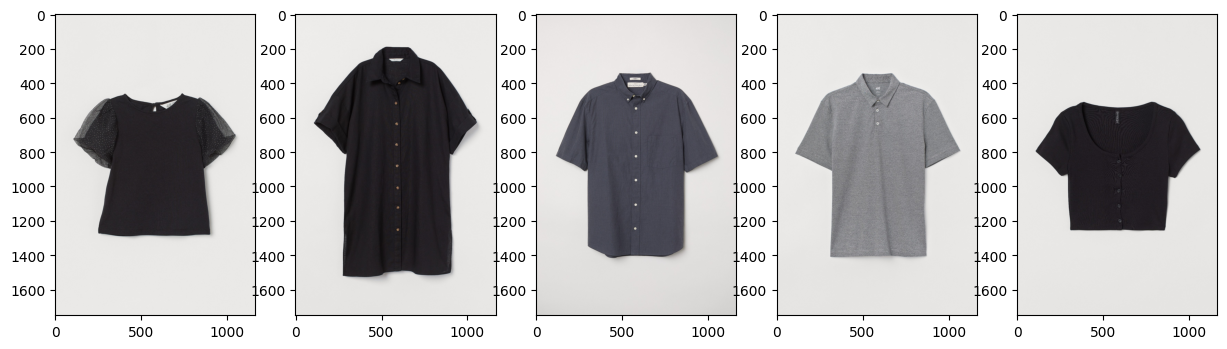

In [47]:
fig, axes = plt.subplots(1, 5, figsize=(15,8))

for i in range(5):
  im = Image.open('data_for_fashion_clip/{0}'.format(results_df.iloc[i]['filename']))
  axes[i].imshow(im)

In [48]:
test_description = "A yellow jacket with stripes"

In [49]:
test_embedding = embedding_from_text(test_description)

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

1it [00:00,  4.47it/s]


In [50]:
results_df = tbl.search(test_embedding).limit(5).to_df().sort_values(by='score', ascending=False)

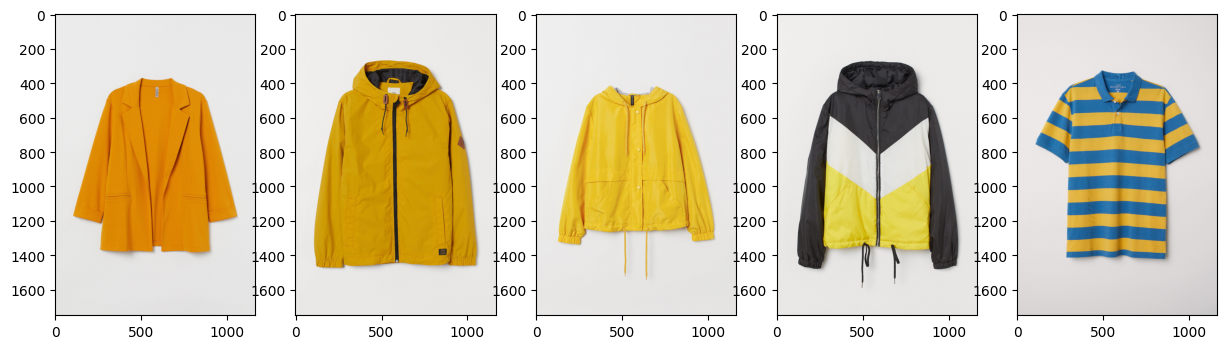

In [51]:
fig, axes = plt.subplots(1, 5, figsize=(15,8))

for i in range(5):
  im = Image.open('data_for_fashion_clip/{0}'.format(results_df.iloc[i]['filename']))
  axes[i].imshow(im)

In [52]:
test_description = "A long red dress"

In [53]:
test_embedding = embedding_from_text(test_description)

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

1it [00:00,  6.33it/s]


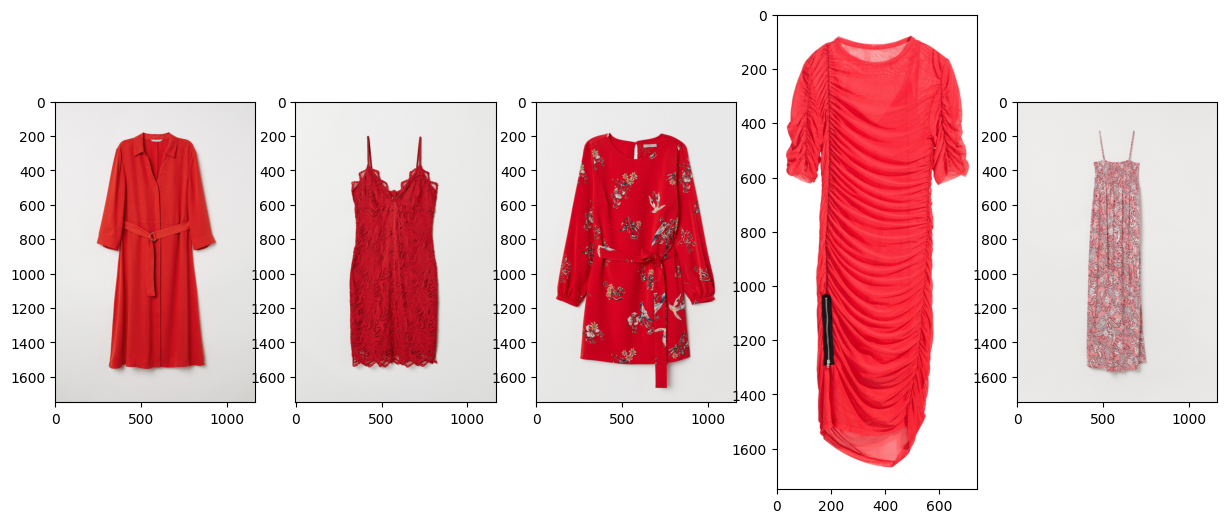

In [54]:
results_df = tbl.search(test_embedding).limit(5).to_df().sort_values(by='score', ascending=False)

fig, axes = plt.subplots(1, 5, figsize=(15,8))

for i in range(5):
  im = Image.open('data_for_fashion_clip/{0}'.format(results_df.iloc[i]['filename']))
  axes[i].imshow(im)